In [2]:
import glob
import json
import gzip
import dill as pickle
import pandas as pd

In [3]:
import sys
import os
# Dynamically get the path of the current directory
current_dir = os.getcwd()

# Assuming the package is one level up
local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
sys.path.insert(0, local_package_dir)

# Now you can import your local package
from util import validate
from util import calculate_response_parallel

In [4]:
def getresveritas(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['veritas']
def getreskappa(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['lower_threshold']
def getresmu(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['score']
def getres(row):
    with open('../../veritas-experiment2/'+row.jsonpath, 'r') as file:
        data = json.load(file)
    return data[0]['responses']
def getsex(row):
    return row.Sex=='Male'
def getethnicity(row):
    if row['Ethnicity simplified'] == 'White':
        return 0
    if row['Ethnicity simplified'] == 'Black':
        return 1
    if row['Ethnicity simplified'] == 'Asian':
        return 2
    if row['Ethnicity simplified'] == 'Mixed':
        return 3
    return 4

def getpklresp(df):
    A=[{k:v} for k,v in ddf['response'].to_dict().items()]
    with gzip.open('../../response_jsons/experiment2alldata-json.pkl.gz','wb') as file:
        pickle.dump(A,file)

filetimes=pd.read_csv('../../veritas-experiment2/filetimes.csv',names=['sz','creation','jsonpath'])
filetimes.creation = pd.to_datetime(filetimes.creation)
filetimes=filetimes.set_index('creation')
#filetimes=filetimes.sort_index().tail(100)
filetimes=filetimes.reset_index()

In [5]:
de1=pd.read_csv('../../veritas-experiment/prolific_export_659b858e59d89ff7f7340157.csv')
de1=de1[de1.Status=='APPROVED']

de2=pd.read_csv('../../veritas-experiment/prolific_export_659b69ff0a427599bec1d811.csv')
de2=de2[de2.Status=='APPROVED']

de=pd.concat([de1,de2]).assign(batch=0)

In [6]:
demog=pd.read_csv('../../veritas-experiment2/prolific_export_65a96448a2efd0a811b1db33-exp2.csv')
demog=demog[demog.Status!='RETURNED']
demog=demog.assign(batch=1)
demog=pd.concat([demog, de])
demog['Completed at']=pd.to_datetime(demog['Completed at'])
demog=demog.set_index('Completed at')
demog=demog.sort_index().reset_index()

demog=demog.join(filetimes)

ddf=demog[['Participant id','Time taken','Age', 'Sex', 'Ethnicity simplified','jsonpath',
           'Country of birth', 'Country of residence', 'Nationality', 'Language',]].set_index('Participant id')

ddf['veritas']=ddf.apply(getresveritas,axis=1)
ddf['kappa']=ddf.apply(getreskappa,axis=1)
ddf['score']=ddf.apply(getresmu,axis=1)
ddf['sex']=ddf.apply(getsex,axis=1)
ddf['ethnicity']=ddf.apply(getethnicity,axis=1)
ddf['Age']=ddf.Age.astype(float)
ddf['response'] = ddf.apply(getres,axis=1)
getpklresp(ddf)

In [7]:
#calculate_response_parallel('../../response_jsons/experiment2alldata-json.pkl.gz','../../veritas_models/veritas_002.pkl.gz','./res_exp2_model2.csv')

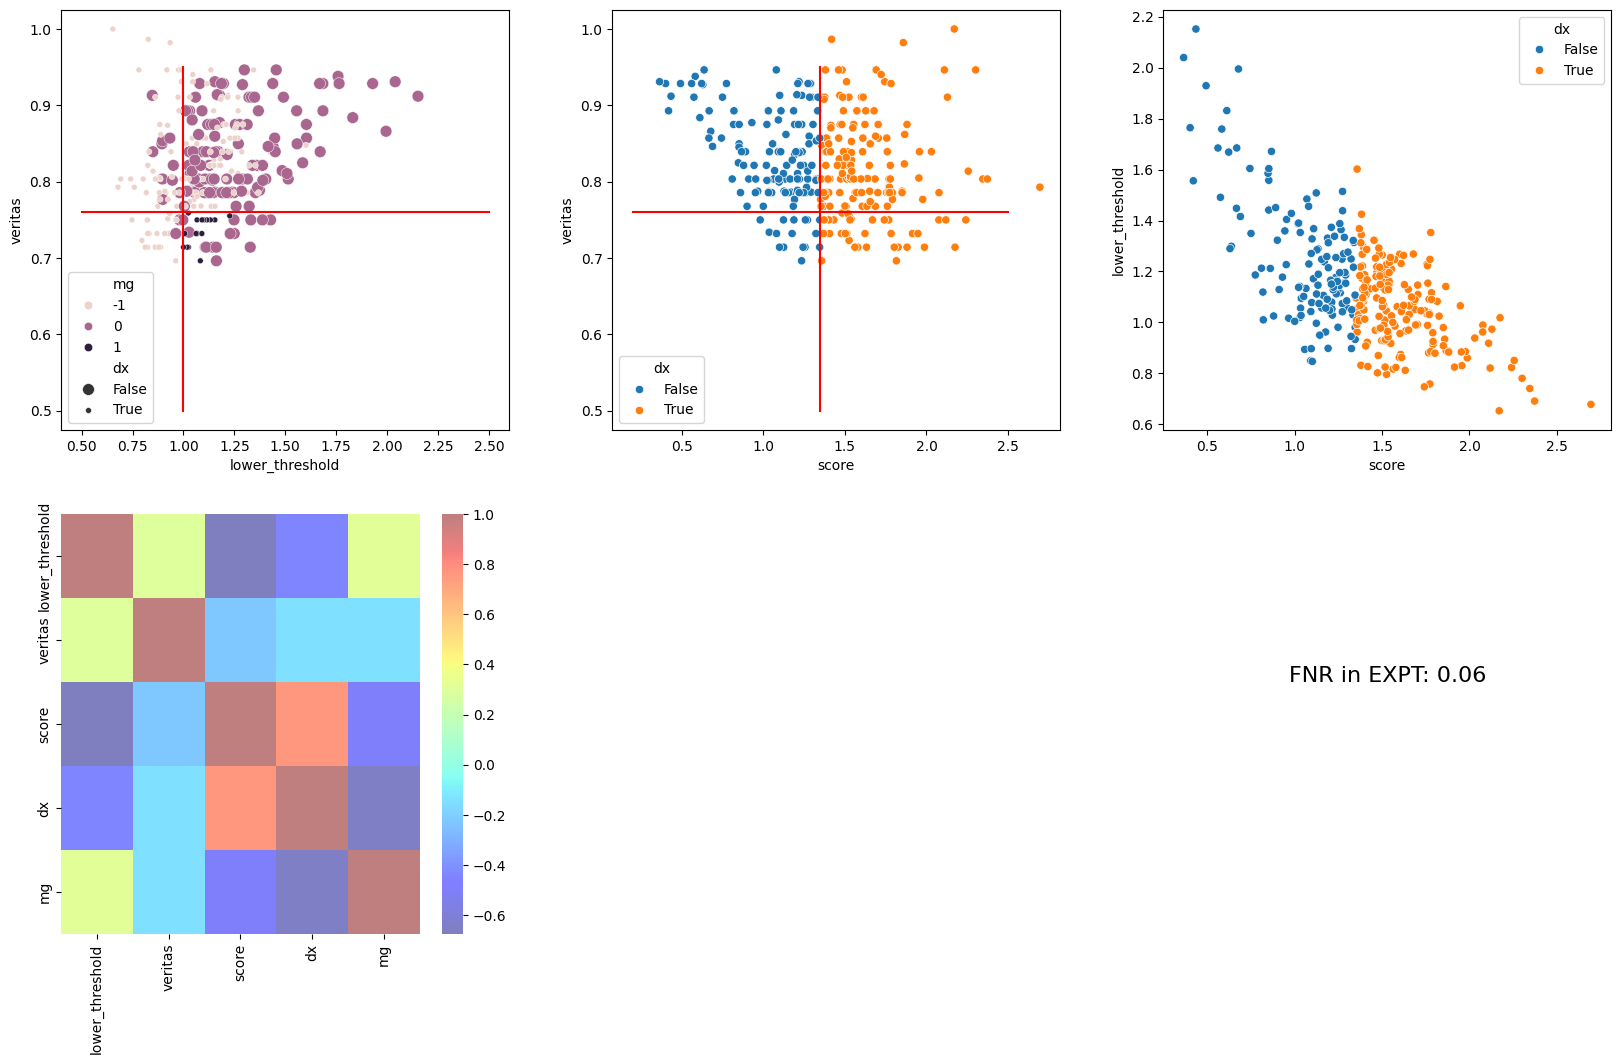

In [8]:
import pandas as pd
resf=pd.read_csv('../../data/res_expbatch012_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
expd2,expf2=validate(resf,C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid2.png',
         validation_type='fnrexpt')

In [9]:
expd2

{'fnr': 0.05806451612903226}

In [105]:
1-expd2['fnr']

0.9419354838709677

In [11]:
expf2['mg'].value_counts()

-1    156
 0    136
 1     18
Name: mg, dtype: int64

In [12]:
resf=expf2.join(ddf.drop(['veritas','score'],axis=1))

In [13]:
resf['mg'].value_counts()

-1    156
 0    136
 1     18
Name: mg, dtype: int64

In [14]:
resf['Ethnicity simplified'].value_counts()

White    220
Black     33
Asian     24
Mixed     20
Other     13
Name: Ethnicity simplified, dtype: int64

<Axes: xlabel='lower_threshold', ylabel='veritas'>

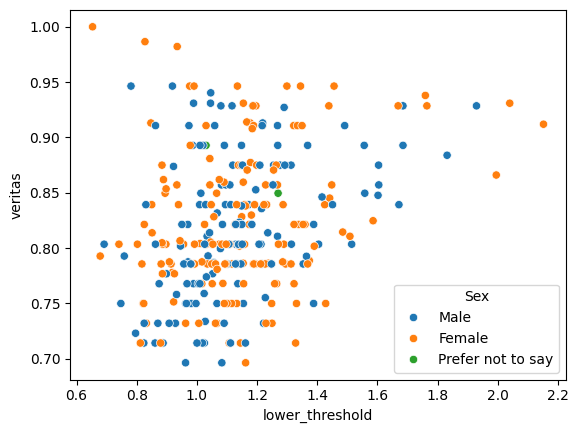

In [15]:
import seaborn as sns
sns.scatterplot(data=resf,y='veritas',x='lower_threshold',hue='Sex')

In [16]:
resf.groupby('mg').mean()

,lower_threshold,veritas,score,dx,Time taken,Age,kappa,sex,ethnicity
mg,,,,,,,,,
-1,1.044532,0.822050,1.625852,1.0,219.897436,41.448718,0.896478,0.442308,0.621795
0,1.247097,0.831626,1.065810,0.0,194.801471,40.242647,1.064329,0.455882,0.610294
1,1.086045,0.735912,1.633796,1.0,181.333333,37.277778,0.953992,0.555556,0.722222


In [17]:
resf.corr()

,lower_threshold,veritas,score,dx,mg,Time taken,Age,kappa,sex,ethnicity
lower_threshold,1.000000,0.295246,-0.674140,-0.440092,0.319511,0.013294,0.001809,0.545667,-0.021101,0.035218
veritas,0.295246,1.000000,-0.225415,-0.143931,-0.139500,0.097930,0.015750,0.009663,-0.034065,0.047233
score,-0.674140,-0.225415,1.000000,0.759512,-0.492299,0.006380,-0.011076,-0.504313,-0.002148,-0.030940
dx,-0.440092,-0.143931,0.759512,1.000000,-0.653110,0.071101,0.027129,-0.308767,-0.001853,0.009601
mg,0.319511,-0.139500,-0.492299,-0.653110,1.000000,-0.091669,-0.068581,0.239850,0.040504,0.009066
Time taken,0.013294,0.097930,0.006380,0.071101,-0.091669,1.000000,0.078561,-0.021514,0.042683,0.129054
Age,0.001809,0.015750,-0.011076,0.027129,-0.068581,0.078561,1.000000,0.072733,0.019882,-0.213852
kappa,0.545667,0.009663,-0.504313,-0.308767,0.239850,-0.021514,0.072733,1.000000,0.072432,0.013516
sex,-0.021101,-0.034065,-0.002148,-0.001853,0.040504,0.042683,0.019882,0.072432,1.000000,-0.038842
ethnicity,0.035218,0.047233,-0.030940,0.009601,0.009066,0.129054,-0.213852,0.013516,-0.038842,1.000000


# generate tables

In [59]:
resf.columns

Index(['lower_threshold', 'veritas', 'score', 'dx', 'mg', 'Time taken', 'Age',
       'Sex', 'Ethnicity simplified', 'jsonpath', 'Country of birth',
       'Country of residence', 'Nationality', 'Language', 'kappa', 'sex',
       'ethnicity', 'response'],
      dtype='object')

In [66]:
mgpos=resf[resf.mg==1]
mgpos=mgpos[['Country of residence','Sex','Ethnicity simplified','Time taken']]
Count=mgpos.groupby(['Country of residence','Sex','Ethnicity simplified']).count().reset_index()['Time taken'].values
mgpos=mgpos.groupby(['Country of residence','Sex','Ethnicity simplified']).mean().reset_index().assign(Count=Count)
display(mgpos)

cf=pd.concat([
pd.DataFrame(resf[resf.mg==1][a].value_counts()).rename(columns={a:'counts'})
    for a in A]).rename(index={'Asian':'\\rowcolor{\\ACOL}Race: Asian', 'Black': '\\rowcolor{\\ACOL}Race: Black', 
                               'Mixed': '\\rowcolor{\\ACOL}Race: Mixed', 'Other': '\\rowcolor{\\ACOL}Race: Other', 
                               'White':'\\rowcolor{\\ACOL}Race: White', 
                             'Female':'\\rowcolor{\\BCOL}Sex: Female', 'Male':'\\rowcolor{\\BCOL}Sex: Male',
       'United Kingdom':'\\rowcolor{\\CCOL}Residence: United Kingdom', 'United States':'\\rowcolor{\\CCOL}Residence: United States'})
cf

,Country of residence,Sex,Ethnicity simplified,Time taken,Count
0,United Kingdom,Female,White,166.0,2
1,United Kingdom,Male,Black,393.0,2
2,United Kingdom,Male,White,262.0,1
3,United States,Female,Asian,172.0,1
4,United States,Female,Black,180.0,3
5,United States,Female,White,133.5,2
6,United States,Male,Asian,87.0,1
7,United States,Male,Black,195.0,1
8,United States,Male,Mixed,191.0,1
9,United States,Male,White,108.0,4


,counts
\rowcolor{\ACOL}Race: White,9
\rowcolor{\ACOL}Race: Black,6
\rowcolor{\ACOL}Race: Asian,2
\rowcolor{\ACOL}Race: Mixed,1
\rowcolor{\BCOL}Sex: Male,10
\rowcolor{\BCOL}Sex: Female,8
\rowcolor{\CCOL}Residence: United States,13
\rowcolor{\CCOL}Residence: United Kingdom,5


In [80]:
A=['Ethnicity simplified','Sex','Country of residence']
pff=pd.concat([resf[[a,'Time taken', 'Age']]\
                    .groupby(a).mean()\
                    .reset_index().assign(Count=resf.groupby(a).count().Age.values\
                    ).rename(columns={a:'characteristics'}) for a in A]).set_index('characteristics').drop(index='Prefer not to say')
pff=pff.round(1).rename(columns={'Time taken':'mean Completion Time [s]','Age':'mean age [years]'},index={'Asian':'\\rowcolor{\\ACOL}Race: Asian', 'Black': '\\rowcolor{\\ACOL}Race: Black', 
                               'Mixed': '\\rowcolor{\\ACOL}Race: Mixed', 'Other': '\\rowcolor{\\ACOL}Race: Other', 
                               'White':'\\rowcolor{\\ACOL}Race: White', 
                             'Female':'\\rowcolor{\\BCOL}Sex: Female', 'Male':'\\rowcolor{\\BCOL}Sex: Male',
       'United Kingdom':'\\rowcolor{\\CCOL}Residence: United Kingdom', 'United States':'\\rowcolor{\\CCOL}Residence: United States'})
pff.reset_index()
pff['success rate (\%)'] = 100*(cf.counts/pff.Count).fillna(0)
pff=pff.round(1).rename(columns={'Count': 'no. of participants'})

from zedstat.textable import textable
textable(pff,tabname='../tex/Figures/tabprolific.tex',FORMAT='%1.1f',INDEX=True,LNTERM='\\\\\\hline\n',TABFORMAT='L{1.8in}|L{1.2in}|L{.8in}|L{.8in}|L{1.2in}')     
pff

,mean Completion Time [s],mean age [years],no. of participants,success rate (\%)
characteristics,,,,
\rowcolor{\ACOL}Race: Asian,188.4,34.3,24,8.3
\rowcolor{\ACOL}Race: Black,329.5,38.0,33,18.2
\rowcolor{\ACOL}Race: Mixed,195.8,31.4,20,5.0
\rowcolor{\ACOL}Race: Other,286.2,38.5,13,0.0
\rowcolor{\ACOL}Race: White,186.5,42.7,220,4.1
\rowcolor{\BCOL}Sex: Female,201.5,40.5,167,4.8
\rowcolor{\BCOL}Sex: Male,213.5,41.0,141,7.1
\rowcolor{\CCOL}Residence: United Kingdom,213.5,43.1,110,4.5
\rowcolor{\CCOL}Residence: United States,202.9,39.4,200,6.5


In [82]:
pff.corr()

,mean Completion Time [s],mean age [years],no. of participants,success rate (\%)
mean Completion Time [s],1.000000,0.000309,-0.493029,0.482812
mean age [years],0.000309,1.000000,0.705140,-0.157084
no. of participants,-0.493029,0.705140,1.000000,-0.192161
success rate (\%),0.482812,-0.157084,-0.192161,1.000000


In [103]:
import numpy as np
import scipy.stats as stats
#import stats
# Fisher Z transformation of the correlation coefficient
rf=pff
z = np.arctanh(rf.corr())

# Standard error (SE) of Z
se = 1 / np.sqrt(rf.index.size - 3)

# Confidence interval levels, e.g., 95%
confidence_level = 0.95
z_critical = stats.norm.ppf((1 + confidence_level) / 2)  # two-tailed

# Confidence interval in Z space
ci_z = [z- z_critical * se,z+ z_critical * se]

# Transform back to correlation coefficient space
ci_corr_coefficient = np.tanh(ci_z)
lcr=pd.DataFrame(ci_corr_coefficient[0],columns=rf.columns,index=rf.corr().index)
ucr=pd.DataFrame(ci_corr_coefficient[1],columns=rf.columns,index=rf.corr().index)
display(lcr,ucr,rf.corr())

,mean Completion Time [s],mean age [years],no. of participants,success rate (\%)
mean Completion Time [s],1.000000,-0.663949,-0.871722,-0.266886
mean age [years],-0.663949,1.000000,0.077145,-0.743628
no. of participants,-0.871722,0.077145,1.000000,-0.759373
success rate (\%),-0.266886,-0.743628,-0.759373,1.000000


,mean Completion Time [s],mean age [years],no. of participants,success rate (\%)
mean Completion Time [s],1.000000,0.664295,0.254387,0.868464
mean age [years],0.664295,1.000000,0.932550,0.566095
no. of participants,0.254387,0.932550,1.000000,0.541002
success rate (\%),0.868464,0.566095,0.541002,1.000000


,mean Completion Time [s],mean age [years],no. of participants,success rate (\%)
mean Completion Time [s],1.000000,0.000309,-0.493029,0.482812
mean age [years],0.000309,1.000000,0.705140,-0.157084
no. of participants,-0.493029,0.705140,1.000000,-0.192161
success rate (\%),0.482812,-0.157084,-0.192161,1.000000


In [ ]:
sns.distplot(resf[resf.mg==1]['Time taken'])
sns.distplot(resf[resf.mg==-1]['Time taken'])

In [3]:
(0.868464+0.266886)/2

0.567675

In [2]:
0.482812+0.8684640.266886

0.749698